# GRE phantom experiment
This notebook presents the GRE phantom experiment performed to assess the accuracy and robustness of the EPT reconstruction method used in this study. We reconstructed the electrical properties of three phantoms with varying saline concentrations ($c_1 = 3\, [\textrm{g.L}^{-1}]$, $c_2 = 6\, [\textrm{g.L}^{-1}]$ and $c_3 = 9\, [\textrm{g.L}^{-1}]$). 

**Acquisition information:** MRI scans of the spherical phantoms (internal diameter $100\, \textrm{mm}$) were performed on a 3T ($f_0 = 128$ MHz) Philips Achieva scanner. We used the same multi-coil sensitivity reference gradient echo (GRE) SENSE sequence as in the neonatal data. This corresponded to complex low resolution ($2.6$ mm isotropic) sensitivity reference scans, including $32$ channels from the array head coil and one from the body coil reference. 

We reconstructed the EPs using the SAEP method and applied the same processing pipeline as for the neonatal GRE data.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import json
import yaml

import seaborn as sns
import matplotlib.pyplot as plt

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.eprecon import *
from utils.preprocess import *
from utils.tools import *
from utils.mask import *

sns.set_theme(style="darkgrid")

## 1. Image pre-processing

### 1.a. Gibbs artefacts correction
Gibbs ringing artefacts were removed from the low-resolution multi-channel complex GRE images using the complex-valued 3D sub-voxel shifts technique of MRtrix.

In [2]:
# Number of phantoms
n = 3

# Set directories
phantom_dir = os.path.join(base_dir, "data", "phantoms")
deriv_dir = os.path.join(phantom_dir, "derivatives")

# Set file path
mag_paths = [os.path.join(phantom_dir, f"ph{i}_mag.nii.gz") for i in range(n)]
pha_paths = [os.path.join(phantom_dir,  f"ph{i}_pha.nii.gz") for i in range(n)]
mag_degibbs_paths = [os.path.join(deriv_dir, f"ph{i}_mag_degibbs.nii.gz") for i in range(n)]
pha_degibbs_paths = [os.path.join(deriv_dir, f"ph{i}_pha_degibbs.nii.gz") for i in range(n)]

# iter over phantoms
for i in range(n):
    # Run DeGibbs correction
    degibbs(
        input_mag_path=mag_paths[i], 
        input_pha_path=pha_paths[i],
        output_mag_path=mag_degibbs_paths[i], 
        output_pha_path=pha_degibbs_paths[i],
        k_window=[6, 90, 7, 90, 32, 93],
    )

### 1.b. Reference coil extraction
The body coil was used for registration and normalization purposes.

In [3]:
# Set file path
mag_ref_paths = [os.path.join(deriv_dir, f"ph{i}_mag_ref.nii.gz") for i in range(n)]

# Iter over phantoms
for i in range(n):
    # Extract reference coil
    extract_reference_coil(
        input_mag_path=mag_degibbs_paths[i],
        output_mag_path=mag_ref_paths[i],
        ref_coil_idx=32,
    )

### 1.c. Binary segmentation
The binary masks used to define the ROI were created using Otsu thresholding.

In [4]:
# Set file path
mask_paths = [os.path.join(deriv_dir, f"ph{i}_mask.nii.gz") for i in range(n)]

# Iter over phantoms
for i in range(n):
    # Aplly binary segmentation
    binary_segmentation(
        input_img_path=mag_ref_paths[i],
        output_mask_path=mask_paths[i], 
    )

## 2. Electrical properties reconstruction from GRE phantoms

### 2.a. Conductivity and permittivity reconstruction using the single-acquisition electrical properties (SAEP) pipeline
The $\sigma$ and $\epsilon_r$ of the phantoms were reconstructed inside the mask using the SAEP method.

**Pipeline parameters:** Gaussian smoothing STD kernel $3.9$ mm, $12$ modes SVD truncation, erosion radius $15.6$ mm.

In [5]:
# Set directories
ep_saep_dir = os.path.join(phantom_dir, "ep_recon_saep")
deriv_saep_dir = os.path.join(phantom_dir, "derivatives")
config_dir = os.path.join(base_dir, "config")

# Set file path
sig_paths = [os.path.join(ep_saep_dir, f"ph{i}_sig.nii.gz") for i in range(n)]
eps_paths = [os.path.join(ep_saep_dir, f"ph{i}_eps.nii.gz") for i in range(n)]
ep_metrics_paths = [os.path.join(ep_saep_dir, f"ph{i}_ep_metrics.json") for i in range(n)]
mask_eroded_paths = [os.path.join(deriv_saep_dir, f"ph{i}_mask_eroded.nii.gz") for i in range(n)]
sig_eroded_paths = [os.path.join(ep_saep_dir, f"ph{i}_sig_eroded.nii.gz") for i in range(n)]
eps_eroded_paths = [os.path.join(ep_saep_dir, f"ph{i}_eps_eroded.nii.gz") for i in range(n)]
config_path = os.path.join(config_dir, "phantom_gre_saep.yaml")

# Load pipeline configuration
kwargs = yaml.safe_load(open(config_path))

# Iter over phantoms
for i in range(n):
    # Run SAEP pipeline
    saep_pipeline(
        input_mag_path=mag_degibbs_paths[i],
        input_pha_path=pha_degibbs_paths[i],
        input_mask_path=mask_paths[i],
        output_sig_path=sig_paths[i],
        output_eps_path=eps_paths[i],
        output_ep_metrics_path=ep_metrics_paths[i],
        output_mask_eroded_path=mask_eroded_paths[i],
        output_sig_eroded_path=sig_eroded_paths[i],
        output_eps_eroded_path=eps_eroded_paths[i],
        **kwargs,
    )

#### Conductivity and permittivity results

In [6]:
# Set file path
gt_ep_metrics_paths = [os.path.join(phantom_dir, f"ph{i}_gt_ep_metrics.json") for i in range(n)]

# Init dataframe
df = {}

#
for i in range(n):
    # Load EP metrics
    ep_metrics = json.load(open(ep_metrics_paths[i]))
    gt_ep_metrics = json.load(open(gt_ep_metrics_paths[i]))
    
    # Display metrics
    print(f"Phantom {i}:")
    print(f"Predicted conductivity: {ep_metrics['SIG']:.2f} ± {ep_metrics['SIG_std']:.2f} [S.m⁻¹]")
    print(f"Ground truth conductivity: {gt_ep_metrics['GT_SIG']:.2f} [S.m⁻¹]")
    print(f"Relative error: {np.abs(ep_metrics['SIG'] - gt_ep_metrics['GT_SIG']) / gt_ep_metrics['GT_SIG'] * 100:.2f} %")
    print(f"Relative STD: {ep_metrics['SIG_std'] / gt_ep_metrics['GT_SIG'] * 100:.2f} %")
    
    print(f"Predicted permittivity: {ep_metrics['EPS']:.2f} ± {ep_metrics['EPS_std']:.2f}")
    print(f"Ground truth permittivity: {gt_ep_metrics['GT_EPS']:.2f}")
    print(f"Relative error: {np.abs(ep_metrics['EPS'] - gt_ep_metrics['GT_EPS']) / gt_ep_metrics['GT_EPS'] * 100:.2f} %")
    print(f"Relative STD: {ep_metrics['EPS_std'] / gt_ep_metrics['GT_EPS'] * 100:.2f} %\n")

    # Concatenate dataframes for plotting
    for key, val in {**ep_metrics, **gt_ep_metrics}.items():
        df.setdefault(key, []).append(val)

Phantom 0:
Predicted conductivity: 0.45 ± 0.30 [S.m⁻¹]
Ground truth conductivity: 0.56 [S.m⁻¹]
Relative error: 20.14 %
Relative STD: 53.27 %
Predicted permittivity: 69.96 ± 58.28
Ground truth permittivity: 80.56
Relative error: 13.16 %
Relative STD: 72.34 %

Phantom 1:
Predicted conductivity: 0.93 ± 0.47 [S.m⁻¹]
Ground truth conductivity: 1.07 [S.m⁻¹]
Relative error: 12.85 %
Relative STD: 44.14 %
Predicted permittivity: 66.25 ± 60.05
Ground truth permittivity: 77.81
Relative error: 14.85 %
Relative STD: 77.17 %

Phantom 2:
Predicted conductivity: 1.41 ± 0.45 [S.m⁻¹]
Ground truth conductivity: 1.53 [S.m⁻¹]
Relative error: 7.92 %
Relative STD: 29.21 %
Predicted permittivity: 61.39 ± 65.48
Ground truth permittivity: 75.13
Relative error: 18.29 %
Relative STD: 87.16 %



### 2.b. Comparison of ground truth and predicted electrical properties measurements 

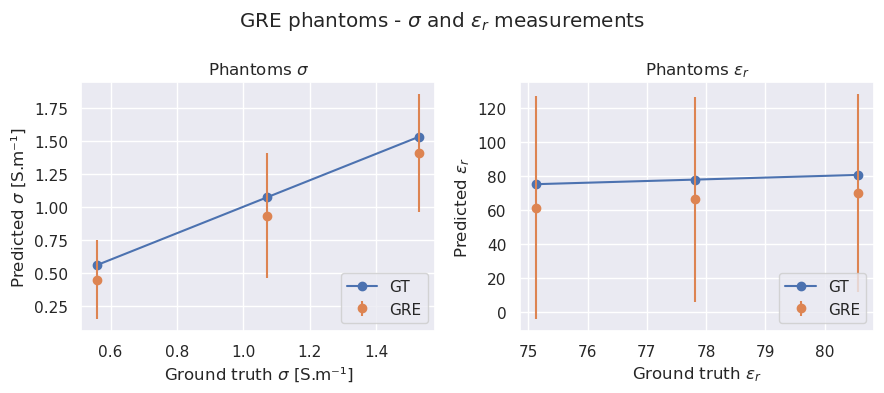

In [7]:
# Set file path
plot_path = os.path.join(base_dir, "plots", "experiments", "phantom_experiment.png")

# EPs labels
EPs = ["SIG", "EPS"]

# Initialize plot
fig, axes = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle(r"GRE phantoms - $\sigma$ and $\epsilon_r$ measurements")

# 
for i, EP in enumerate(EPs):

    # Plot reference line
    axes[i].plot(df[f"GT_{EP}"], df[f"GT_{EP}"], "-o", label="GT")
    
    # Plot predictions with error bars
    axes[i].errorbar(df[f"GT_{EP}"], df[EP], yerr=df[f"{EP}_std"], fmt='o', label="GRE")
    
    # Set labels and title
    axes[i].set_title(f"Phantoms {r'$\sigma$' if i == 0 else r'$\epsilon_r$'}")
    axes[i].set_xlabel(f"Ground truth {r'$\sigma$ [S.m⁻¹]' if i == 0 else r'$\epsilon_r$'}")
    axes[i].set_ylabel(f"Predicted {r'$\sigma$ [S.m⁻¹]' if i == 0 else r'$\epsilon_r$'}")
    axes[i].legend(loc="lower right")

# Adjust layout
fig.tight_layout()

# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)